In [1]:
import pickle
import numpy as np
model_list=["mini_rag","qag_llm_7B","qwen2.5-7b-instruct-1m",
            "qag_llm_14B","qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b","mini_rag_de2chunks","mini_rag_debm25"]

qa_embs=[[] for _ in model_list]
with open('qa_embs.pkl', 'rb') as file:
    qa_emb = pickle.load(file)
with open('qa_embs_1.pkl', 'rb') as file:
    qa_emb_1 = pickle.load(file)
with open('qa_embs_Ablation.pkl', 'rb') as file:
    qa_emb_2 = pickle.load(file)
qa_embs[0]=qa_emb[0]
qa_embs[1]=qa_emb[1]
qa_embs[2]=qa_emb_1[6]
qa_embs[3]=qa_emb_1[0]
qa_embs[4]=qa_emb[2]
qa_embs[5]=qa_emb[3]
qa_embs[6]=qa_emb_1[1]
qa_embs[7]=qa_emb_1[4]
qa_embs[8]=qa_emb_1[3]
qa_embs[9]=qa_emb_1[2]
qa_embs[10]=qa_emb_1[5]
qa_embs[11]=qa_emb_1[7]
qa_embs[12]=qa_emb_2[0]
qa_embs[13]=qa_emb_2[1]

In [2]:
import pickle
import numpy as np
model_list=["mini_rag","qag_llm_7B","qwen2.5-7b-instruct-1m",
            "qag_llm_14B","qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b"]

qa_embs={}
with open('qa_embs.pkl', 'rb') as file:
    qa_emb = pickle.load(file)
with open('qa_embs_1.pkl', 'rb') as file:
    qa_emb_1 = pickle.load(file)
qa_embs[model_list[0]]=qa_emb[0]
qa_embs[model_list[1]]=qa_emb[1]
qa_embs[model_list[2]]=qa_emb_1[6]
qa_embs[model_list[3]]=qa_emb_1[0]
qa_embs[model_list[4]]=qa_emb[2]
qa_embs[model_list[5]]=qa_emb[3]
qa_embs[model_list[6]]=qa_emb_1[1]
qa_embs[model_list[7]]=qa_emb_1[4]
qa_embs[model_list[8]]=qa_emb_1[3]
qa_embs[model_list[9]]=qa_emb_1[2]
qa_embs[model_list[10]]=qa_emb_1[5]
qa_embs[model_list[11]]=qa_emb_1[7]
with open('QAs_embs.pkl', 'wb') as file:
    pickle.dump(qa_embs,file)

In [3]:
with open('QAs_embs.pkl', 'rb') as file:
    qa_embs = pickle.load(file)

In [2]:
import pandas as pd
def mid(x):
    if x%2==0:
        return x/2-1,x/2-1
    else:
        return int(x/2)-1,int(x/2)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
for i in range(6):
    chunks=5*(i+1)
    with open(f'article_embs_{chunks}chunks.pkl', 'rb') as file:
        article_emb = pickle.load(file)

    relavance=[[] for _ in qa_embs]
    for i in range(len(qa_embs)):
        scores=[]
        for j in range(30):
            ##qa
            for k in qa_embs[i][j]:
                q=k[0]
                a=k[1]
                s=0
                for p in article_emb[j]:
                    s=s+q.dot(p)+a.dot(p)
                s=s/len(article_emb[j])
                scores.append(s)
        relavance[i].append(scores)
    
    completeness=[[] for _ in qa_embs]
    QA_filds=[[] for _ in qa_embs]
    for i in range(30):
        for j in range(len(qa_embs)):
            q_filds=[]
            a_filds=[]
    
            for k in qa_embs[j][i]:
                q_fild=[]
                a_fild=[]
                for p in article_emb[i]:
                    q_fild.append(p.dot(k[0]))
                    a_fild.append(p.dot(k[1]))
                q_fild_ = np.array(q_fild)
                a_fild_ = np.array(a_fild)
                # 计算逐元素乘积
                qam = np.multiply(q_fild_, a_fild_)
                # ((问题与答案的相似度) * [Σ (答案分块相似度 * 问题分块相似度)] / [Σ 问题分块相似度])^0.5
                score=(k[0].dot(k[1])*sum(qam)/sum(q_fild))**0.5
                q_filds.append(q_fild)
                a_filds.append(a_fild)
                if score>=1:
                    completeness[j].append(1)
                else:
                    completeness[j].append(score)
            QA_filds[j].append({'q_filds':q_filds,'a_filds':a_filds})
    
    ##准确性
    accuracy=[[] for _ in qa_embs]
    for i in range(30):
        for k in range(len(qa_embs)):
            for j in range(len(qa_embs[k][i])):
                q_filds_reverse=QA_filds[k][i]['q_filds'][j].copy()
                q_filds_reverse.sort(reverse=True)
                a_filds_reverse=QA_filds[k][i]['a_filds'][j].copy()
                a_filds_reverse.sort(reverse=True)
                pre,aft=mid(chunks)
                pre=int(pre)
                aft=int(aft)
                q_top5_value=(q_filds_reverse[pre]+q_filds_reverse[aft])/2
                a_top5_value=(a_filds_reverse[pre]+a_filds_reverse[aft])/2
                rel=[]
                ref=[]
                n_cor=0
                for p in range(len(QA_filds[k][i]['q_filds'][j])):
                    if QA_filds[k][i]['q_filds'][j][p]>0.6*0.5+0.5*q_top5_value:
                        rel.append(p)
                    if QA_filds[k][i]['a_filds'][j][p]>0.7*0.5+0.5*((q_top5_value*a_top5_value))**0.5:
                        ref.append(p)
                for p in ref:
                    if p in rel:
                        n_cor=n_cor+1
                score=n_cor/max(1,len(rel))
                accuracy[k].append(min(1,score))
    relavance_s=[]
    completeness_s=[]
    accuracy_s=[]
    for i in range(len(qa_embs)):
    
        relavance_s.append(sum([k for j in relavance[i] for k in j])/len([k for j in relavance[i] for k in j]))
        completeness_s.append(sum(completeness[i])/len((completeness[i])))
        accuracy_s.append(sum(accuracy[i])/len(accuracy[i]))
    
    
    relavance_s[0]=relavance_s[0]*30/29
    relavance_s=np.array(relavance_s)
    relavance_s=(sigmoid(relavance_s/2)*relavance_s/2)**0.5
    relavance_s=relavance_s.tolist()
    data=pd.DataFrame({"model":model_list,"relavance":relavance_s,"completeness":completeness_s,"accuracy":accuracy_s})
    data.to_csv(f'test{chunks}.csv')

In [5]:
[0,1,2]+[3,4,5]

[0, 1, 2, 3, 4, 5]

In [16]:
import numpy as np
import pandas as pd
data={}
data["relevance"]=[]
data["completeness"]=[]
data["accuracy"]=[]
data["total"]=[]
for i in range(6):
    data1=pd.read_csv(f"test{5*(i+1)}.csv")
    data["relevance"].append(data1["relavance"].rank(method='first',ascending=False).to_list())
    data["completeness"].append(data1["completeness"].rank(method='first',ascending=False).to_list())
    data["accuracy"].append(data1["accuracy"].rank(method='first',ascending=False).to_list())
    data["total"].append((data1["relavance"]+data1["completeness"]+data1["accuracy"]).rank(method='first',ascending=False).to_list())

data["relevance"]=np.array(data["relevance"]).T
data["completeness"]=np.array(data["completeness"]).T
data["accuracy"]=np.array(data["accuracy"]).T
data["total"]=np.array(data["total"]).T

In [4]:
data

{'relevance': array([[ 4.,  2.,  3.,  2.,  2.,  2.],
        [ 2.,  3.,  2.,  3.,  3.,  3.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [13., 13., 13., 13., 13., 13.],
        [ 3.,  4.,  4.,  4.,  4.,  4.],
        [ 6.,  6.,  6.,  6.,  6.,  6.],
        [10., 11., 11., 11., 11., 11.],
        [ 5.,  5.,  5.,  5.,  5.,  5.],
        [14., 14., 14., 14., 14., 14.],
        [11., 12., 12., 12., 12., 12.],
        [ 7.,  7.,  7.,  7.,  7.,  8.],
        [ 9.,  9.,  9.,  9.,  9.,  9.],
        [ 8.,  8.,  8.,  8.,  8.,  7.],
        [12., 10., 10., 10., 10., 10.]]),
 'completeness': array([[ 3.,  3.,  3.,  3.,  3.,  3.],
        [ 9.,  9.,  9.,  9.,  9.,  9.],
        [ 6.,  6.,  6.,  6.,  6.,  6.],
        [11., 11., 11., 11., 11., 11.],
        [ 4.,  4.,  4.,  4.,  4.,  4.],
        [ 8.,  8.,  8.,  8.,  8.,  8.],
        [13., 13., 13., 13., 13., 13.],
        [ 5.,  5.,  5.,  5.,  5.,  5.],
        [14., 14., 14., 14., 14., 14.],
        [10., 10., 10., 10., 10., 10.],
        [

Kendall Tau:
        5     10     15     20     25     30
5   1.000  0.780  0.736  0.758  0.758  0.692
10  0.780  1.000  0.912  0.890  0.890  0.912
15  0.736  0.912  1.000  0.934  0.934  0.912
20  0.758  0.890  0.934  1.000  1.000  0.934
25  0.758  0.890  0.934  1.000  1.000  0.934
30  0.692  0.912  0.912  0.934  0.934  1.000

Spearman Rho:
        5     10     15     20     25     30
5   1.000  0.903  0.855  0.859  0.859  0.842
10  0.903  1.000  0.978  0.974  0.974  0.974
15  0.855  0.978  1.000  0.982  0.982  0.969
20  0.859  0.974  0.982  1.000  1.000  0.987
25  0.859  0.974  0.982  1.000  1.000  0.987
30  0.842  0.974  0.969  0.987  0.987  1.000


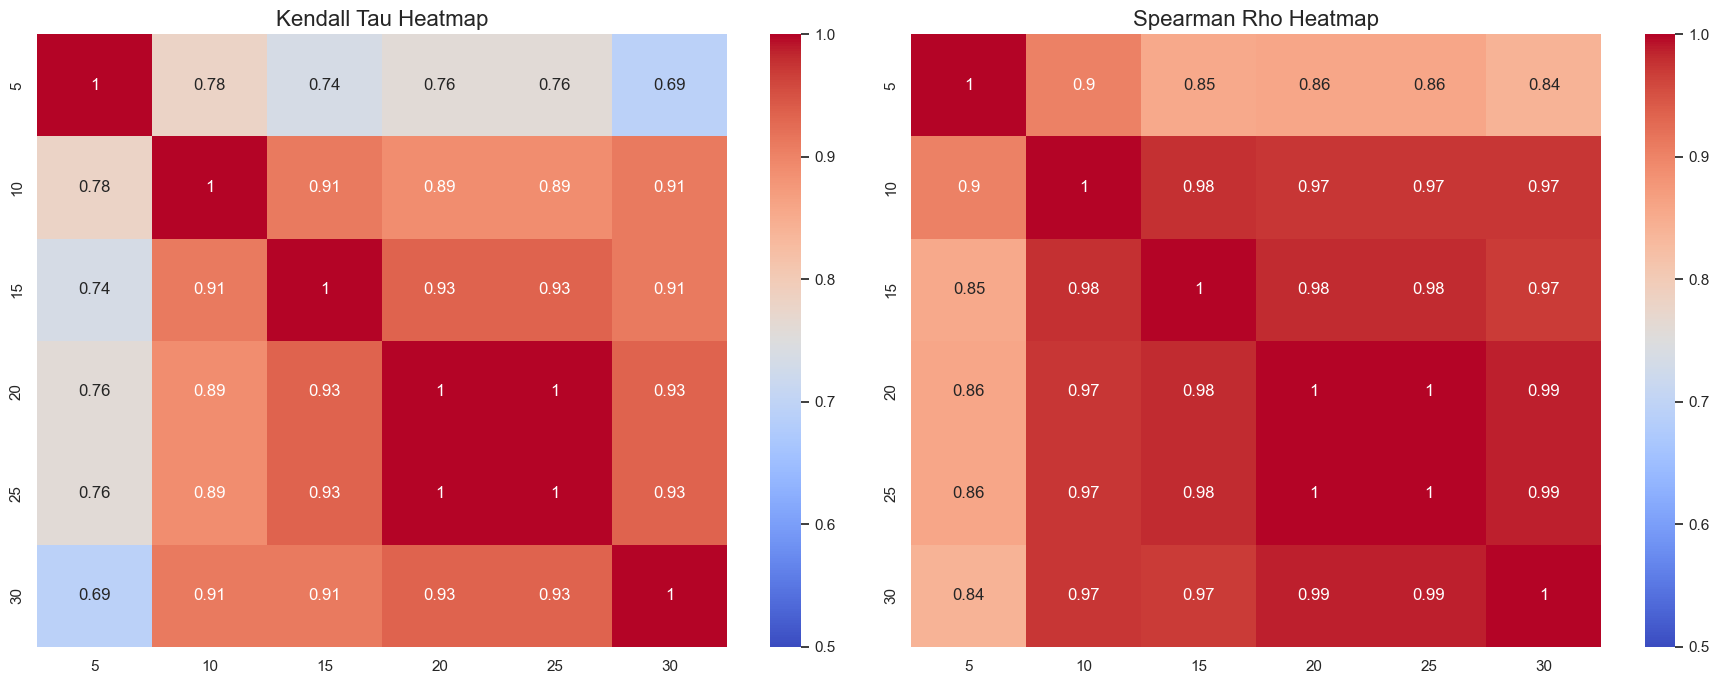

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# rankings = np.array([
#     [7,5,2,2,1,1,1,1,1],
#     [11,11,11,11,11,11,11,9,8],
#     [9,9,10,10,10,10,8,8,9],
#     [10,10,9,9,8,7,6,5,5],
#     [6,7,8,8,9,9,10,10,10],
#     [8,8,7,7,6,6,7,7,7],
#     [1,1,1,1,2,2,2,2,2],
#     [2,2,4,5,5,5,5,6,6],
#     [12,12,12,12,12,12,12,12,12],
#     [4,4,5,4,4,4,4,4,4],
#     [3,6,6,6,7,8,9,11,11],
#     [5,3,3,3,3,3,3,3,3],
# ])
rankings = data["total"]
from scipy.stats import kendalltau, spearmanr
import pandas as pd

# 权重列表
# weights = ['0.1,0.9', '0.2,0.8', '0.3,0.7', '0.4,0.6', '0.5,0.5', 
#            '0.6,0.4', '0.7,0.3', '0.8,0.2', '0.9,0.1']
weights=["5","10","15","20","25","30"]
# 初始化结果表
kendall_matrix = np.zeros((len(weights), len(weights)))
spearman_matrix = np.zeros((len(weights), len(weights)))

# 计算秩相关
for i in range(len(weights)):
    for j in range(len(weights)):
        tau, _ = kendalltau(rankings[:,i], rankings[:,j])
        rho, _ = spearmanr(rankings[:,i], rankings[:,j])
        kendall_matrix[i,j] = tau
        spearman_matrix[i,j] = rho

# 转为DataFrame好看
kendall_df = pd.DataFrame(kendall_matrix, index=weights, columns=weights)
spearman_df = pd.DataFrame(spearman_matrix, index=weights, columns=weights)
kendall_df.to_csv("kendall_df")
spearman_df.to_csv("spearman_df")
print("Kendall Tau:")
print(kendall_df.round(3))
print("\nSpearman Rho:")
print(spearman_df.round(3))
# 绘制热力图
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(kendall_df, annot=True, cmap="coolwarm", vmin=0.5, vmax=1, ax=axes[0])
axes[0].set_title("Kendall Tau Heatmap", fontsize=16)

sns.heatmap(spearman_df, annot=True, cmap="coolwarm", vmin=0.5, vmax=1, ax=axes[1])
axes[1].set_title("Spearman Rho Heatmap", fontsize=16)

plt.tight_layout()
plt.savefig("relavance&completeness&accuracy.png", bbox_inches='tight', dpi=300)  # 保存高清图
plt.show()

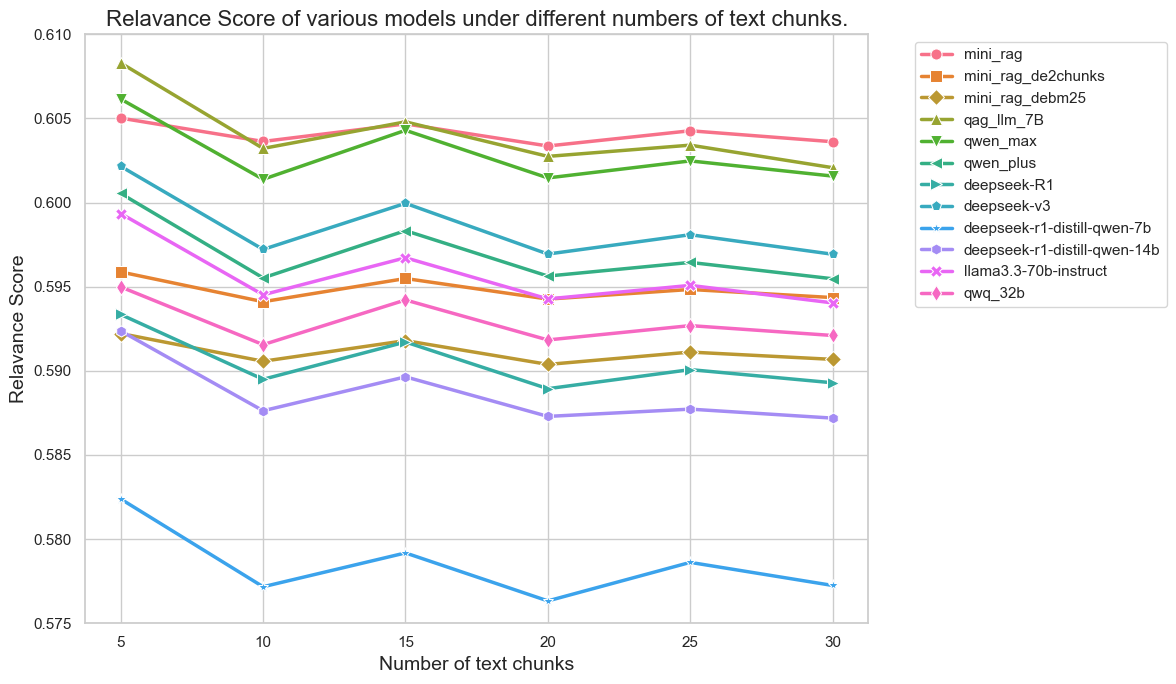

In [12]:
import numpy as np
import pandas as pd
model_list=["mini_rag","qag_llm_7B","qwen2.5-7b-instruct-1m",
            "qag_llm_14B","qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b","mini_rag_de2chunks","mini_rag_debm25"]

model_list_1=["mini_rag","mini_rag_de2chunks","mini_rag_debm25","qag_llm_7B",
            "qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b"
            ]
data={}
for i in model_list_1:
    data[i]=[]
for i in range(6):
    data1=pd.read_csv(f"test{5*(i+1)}.csv")
    c=0
    for j in data1["relavance"]:
        if model_list[c] in model_list_1:
            data[model_list[c]].append(j)
        c=c+1


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 准备数据
weights=["5","10","15","20","25","30"]
# 改进方案1：使用高对比度调色板
palette = sns.color_palette("husl", n_colors=len(model_list_1))

# 改进方案2：添加不同标记样式
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'X', 'd']

# 转换为 DataFrame 方便画图
df = pd.DataFrame(data, index=weights).reset_index().melt(id_vars='index', var_name='Model', value_name='Score')
df.rename(columns={'index': 'Number of text chunks'}, inplace=True)

# 设定 seaborn 风格
sns.set(style="whitegrid")

# 绘制折线图
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df,
    x='Number of text chunks',
    y='Score',
    hue='Model',
    style='Model',  # 为不同模型添加不同样式
    markers=markers[:len(model_list_1)],  # 确保标记数量匹配
    dashes=False,  # 禁用虚线
    palette=palette,  # 使用高对比度颜色
    markersize=8,  # 增大标记尺寸
    linewidth=2.5   # 增加线宽
)

# 添加标题和标签
plt.title('Relavance Score of various models under different numbers of text chunks.', fontsize=16)
plt.xlabel('Number of text chunks', fontsize=14)
plt.ylabel('Relavance Score', fontsize=14)
plt.ylim(0.575, 0.61)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("Relavance Score.png", bbox_inches='tight', dpi=300)  # 保存高清图
plt.show()

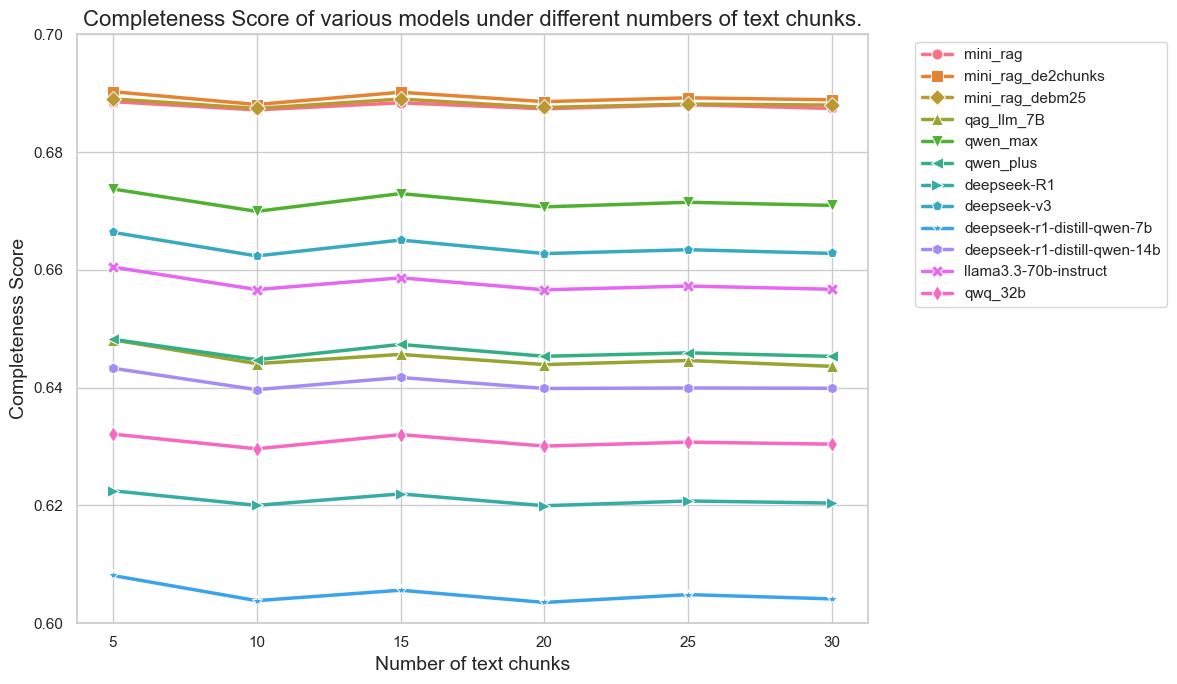

In [11]:
import numpy as np
import pandas as pd


model_list=["mini_rag","qag_llm_7B","qwen2.5-7b-instruct-1m",
            "qag_llm_14B","qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b","mini_rag_de2chunks","mini_rag_debm25"]

model_list_1=["mini_rag","mini_rag_de2chunks","mini_rag_debm25","qag_llm_7B",
            "qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b"
            ]
data={}
for i in model_list_1:
    data[i]=[]
for i in range(6):
    data1=pd.read_csv(f"test{5*(i+1)}.csv")
    c=0
    for j in data1["completeness"]:
        if model_list[c] in model_list_1:
            data[model_list[c]].append(j)
        c=c+1

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 准备数据
weights=["5","10","15","20","25","30"]
# 改进方案1：使用高对比度调色板
palette = sns.color_palette("husl", n_colors=len(model_list_1))

# 改进方案2：添加不同标记样式
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'X', 'd']

# 转换为 DataFrame 方便画图
df = pd.DataFrame(data, index=weights).reset_index().melt(id_vars='index', var_name='Model', value_name='Score')
df.rename(columns={'index': 'Number of text chunks'}, inplace=True)

# 设定 seaborn 风格
sns.set(style="whitegrid")

# 绘制折线图
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df,
    x='Number of text chunks',
    y='Score',
    hue='Model',
    style='Model',  # 为不同模型添加不同样式
    markers=markers[:len(model_list_1)],  # 确保标记数量匹配
    dashes=False,  # 禁用虚线
    palette=palette,  # 使用高对比度颜色
    markersize=8,  # 增大标记尺寸
    linewidth=2.5   # 增加线宽
)

# 添加标题和标签
plt.title('Completeness Score of various models under different numbers of text chunks.', fontsize=16)
plt.xlabel('Number of text chunks', fontsize=14)
plt.ylabel('Completeness Score', fontsize=14)
plt.ylim(0.6, 0.70)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("Completeness Score.png", bbox_inches='tight', dpi=300)  # 保存高清图
plt.show()

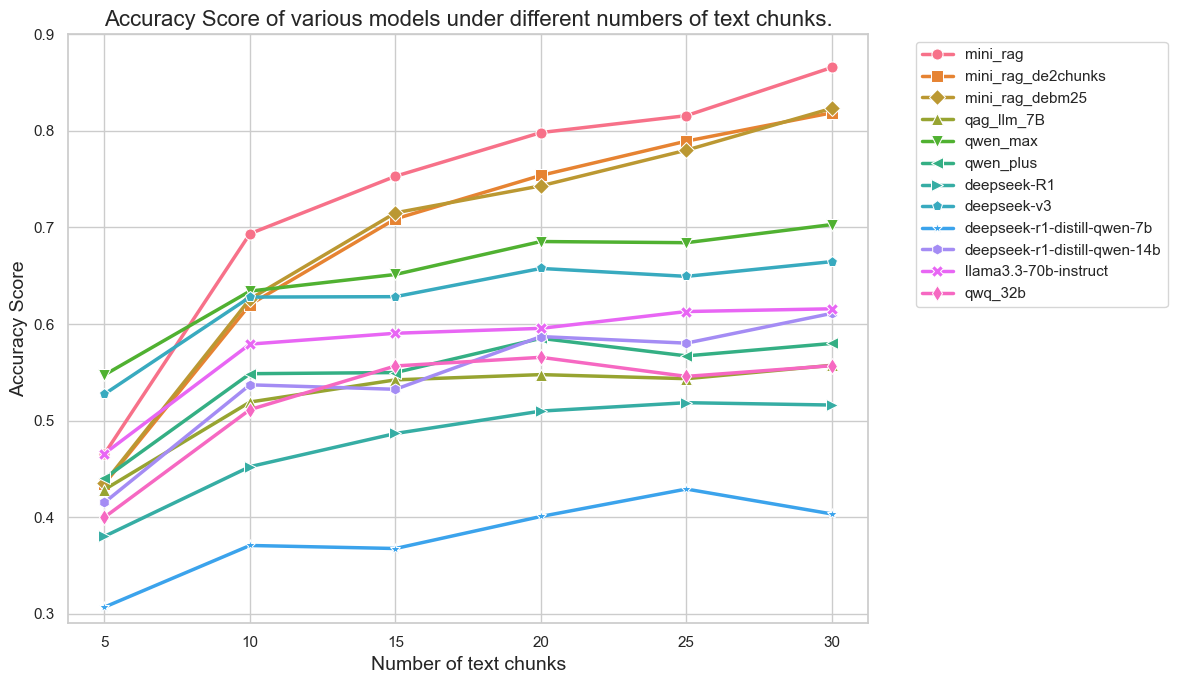

In [14]:
import numpy as np
import pandas as pd

model_list=["mini_rag","qag_llm_7B","qwen2.5-7b-instruct-1m",
            "qag_llm_14B","qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b","mini_rag_de2chunks","mini_rag_debm25"]

model_list_1=["mini_rag","mini_rag_de2chunks","mini_rag_debm25","qag_llm_7B",
            "qwen_max","qwen_plus","deepseek-R1",
            "deepseek-v3","deepseek-r1-distill-qwen-7b",
            "deepseek-r1-distill-qwen-14b","llama3.3-70b-instruct","qwq_32b"
            ]
data={}
for i in model_list_1:
    data[i]=[]
for i in range(6):
    data1=pd.read_csv(f"test{5*(i+1)}.csv")
    c=0
    for j in data1["accuracy"]:
        if model_list[c] in model_list_1:
            data[model_list[c]].append(j)
        c=c+1


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 准备数据
weights=["5","10","15","20","25","30"]
# 改进方案1：使用高对比度调色板
palette = sns.color_palette("husl", n_colors=len(model_list_1))

# 改进方案2：添加不同标记样式
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'X', 'd']

# 转换为 DataFrame 方便画图
df = pd.DataFrame(data, index=weights).reset_index().melt(id_vars='index', var_name='Model', value_name='Score')
df.rename(columns={'index': 'Number of text chunks'}, inplace=True)

# 设定 seaborn 风格
sns.set(style="whitegrid")

# 绘制折线图
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df,
    x='Number of text chunks',
    y='Score',
    hue='Model',
    style='Model',  # 为不同模型添加不同样式
    markers=markers[:len(model_list_1)],  # 确保标记数量匹配
    dashes=False,  # 禁用虚线
    palette=palette,  # 使用高对比度颜色
    markersize=8,  # 增大标记尺寸
    linewidth=2.5   # 增加线宽
)

# 添加标题和标签
plt.title('Accuracy Score of various models under different numbers of text chunks.', fontsize=16)
plt.xlabel('Number of text chunks', fontsize=14)
plt.ylabel('Accuracy Score', fontsize=14)
plt.ylim(0.29, 0.9)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("Accuracy Score.png", bbox_inches='tight', dpi=300)  # 保存高清图
plt.show()